In [2]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Loading data

In [4]:
df=pd.read_csv("triage.csv.gz")

In [5]:
df.sample(5)

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
397743,19353810,31920651,98.4,70.0,18.0,99.0,188.0,80.0,0,3.0,N/V
348472,18193563,30847143,98.8,64.0,18.0,100.0,179.0,56.0,0,3.0,Dyspnea
157696,13735655,32513605,98.4,65.0,18.0,100.0,186.0,94.0,8,3.0,"Abd pain, Headache"
192700,14539981,38826214,97.1,109.0,18.0,96.0,150.0,90.0,10,2.0,LLQ abdominal pain
270888,16370759,31182627,98.8,91.0,18.0,97.0,98.0,52.0,4,2.0,FEVER


In [6]:
df.columns

Index(['subject_id', 'stay_id', 'temperature', 'heartrate', 'resprate',
       'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint'],
      dtype='object')

# Basic data understanding

In [7]:
df.shape

(425087, 11)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425087 entries, 0 to 425086
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   subject_id      425087 non-null  int64  
 1   stay_id         425087 non-null  int64  
 2   temperature     401672 non-null  float64
 3   heartrate       407997 non-null  float64
 4   resprate        404734 non-null  float64
 5   o2sat           404491 non-null  float64
 6   sbp             406796 non-null  float64
 7   dbp             405996 non-null  float64
 8   pain            412154 non-null  object 
 9   acuity          418100 non-null  float64
 10  chiefcomplaint  425064 non-null  object 
dtypes: float64(7), int64(2), object(2)
memory usage: 35.7+ MB


## Duplicate

In [9]:
print(df.duplicated().sum())

0


### Droping columns
Chiefcomplaint is drop

In [10]:
column_to_drop = ['chiefcomplaint']
df = df.drop(columns=column_to_drop)
df

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity
0,10000032,32952584,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0
1,10000032,33258284,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0
2,10000032,35968195,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0
3,10000032,38112554,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0
4,10000032,39399961,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0
...,...,...,...,...,...,...,...,...,...,...
425082,19999784,37972930,98.0,91.0,16.0,99.0,148.0,90.0,5,2.0
425083,19999828,30712109,98.1,83.0,18.0,100.0,107.0,75.0,8,2.0
425084,19999828,32917002,96.6,112.0,18.0,100.0,110.0,82.0,4,2.0
425085,19999914,32002659,99.5,81.0,10.0,100.0,93.0,55.0,0,2.0


## **Treating the pain attribute**

In [11]:
df.shape

(425087, 10)

In [12]:
pain_counts = df[['pain']].value_counts()
pain_counts

pain    
0           140719
8            41730
10           40914
7            31423
5            29210
             ...  
?10              1
A little         1
AMS              1
ASLEEP           1
yes.             1
Length: 847, dtype: int64

In [13]:
pain_counts = df.groupby(['pain']).size().reset_index(name='counts')
print(pain_counts)

               pain  counts
0               6-9       1
1                 0      11
2                10       4
3                 4       1
4                 6       2
..              ...     ...
842             yes     109
843            yes        1
844     yes - R arm       1
845  yes everywhere       1
846            yes.       1

[847 rows x 2 columns]


In [14]:
# Assuming 'pain' column contains a mix of integers, strings, and null values
pain_counts = df['pain'].apply(lambda x: type(x).__name__ if x is not None else 'null').value_counts()
print(pain_counts)


str      412154
float     12933
Name: pain, dtype: int64


In [15]:
# Identify and handle non-numeric values
non_numeric_values = pd.to_numeric(df['pain'], errors='coerce').isna()
df.loc[non_numeric_values, 'pain'] = None  # Replace non-numeric values with NaN

# Convert the 'pain' column to numeric
df['pain'] = pd.to_numeric(df['pain'], errors='coerce')


In [16]:
df.shape

(425087, 10)

In [17]:
pain_counts = df['pain'].value_counts()
pain_counts

0.000     140811
8.000      41748
10.000     41008
7.000      31428
5.000      29220
           ...  
61.000         1
7.235          1
6.830          1
27.000         1
51.000         1
Name: pain, Length: 85, dtype: int64

## **Checking the null value**

In [18]:
df.isnull().sum()

subject_id         0
stay_id            0
temperature    23415
heartrate      17090
resprate       20353
o2sat          20596
sbp            18291
dbp            19091
pain           28114
acuity          6987
dtype: int64

In [19]:
df.dropna(inplace=True)

In [20]:
df.shape

(380155, 10)

###  Analysing Categorical data

In [21]:
acuity_counts=df['acuity'].value_counts()
acuity_counts

3.0    213394
2.0    125926
4.0     27330
1.0     12477
5.0      1028
Name: acuity, dtype: int64

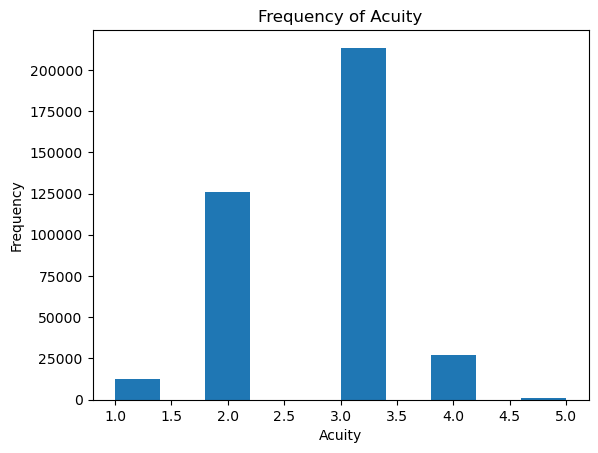

In [22]:
# Plotting the histogram
plt.hist(df['acuity'])
plt.xlabel('Acuity')
plt.ylabel('Frequency')
plt.title('Frequency of Acuity')
plt.show()

### Statical summary

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
subject_id,380155.0,1.501128e+07,2.880685e+06,10000032.0,12521030.0,15018799.0,17509102.5,19999914.0
stay_id,380155.0,3.499820e+07,2.887829e+06,30000012.0,32499877.5,34995224.0,37504995.0,39999965.0
temperature,380155.0,9.801493e+01,3.801679e+00,0.1,97.5,98.0,98.6,986.0
heartrate,380155.0,8.490196e+01,1.763433e+01,1.0,72.0,84.0,96.0,1109.0
resprate,380155.0,1.751814e+01,5.556865e+00,0.0,16.0,18.0,18.0,1820.0
o2sat,380155.0,9.851136e+01,1.717918e+01,0.0,97.0,99.0,100.0,9322.0
sbp,380155.0,1.351376e+02,3.882060e+01,5.0,120.0,133.0,148.0,19734.0
dbp,380155.0,8.120994e+01,1.086728e+03,0.0,68.0,77.0,87.0,661672.0
pain,380155.0,4.422031e+00,4.051333e+00,-1.0,0.0,5.0,8.0,134.0
acuity,380155.0,2.680409e+00,6.656604e-01,1.0,2.0,3.0,3.0,5.0


#### Handling the outlier in data

### using z-score

In [24]:
# from scipy.stats import zscore
# z_scores = zscore(df)
# columnas = ['subject_id', 'stay_id', 'temperature', 'heartrate', 'resprate',
#             'o2sat', 'sbp', 'dbp','pain']
# # Set a threshold
# threshold = 5

# # Create a DataFrame of outliers (absolute Z-score greater than threshold)
# outliers_df = pd.DataFrame((abs(z_scores) > threshold), columns=columnas)

# outlier_counts = outliers_df.sum()
# print(outlier_counts)

# df= df[~outliers_df.any(axis=1)]

# # # Reset the index of the filtered DataFrame
# df.reset_index(drop=True, inplace=True)



In [25]:
# df.shape

### Outlier testing using IQR

In [26]:

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a DataFrame of outliers
outliers_df = ((df < lower_bound) | (df > upper_bound))

# Print the count of outliers for each column
outlier_counts = outliers_df.sum()
print(outlier_counts)

# Filter the DataFrame to exclude outliers
df = df[~outliers_df.any(axis=1)]

# Reset the index of the filtered DataFrame
df.reset_index(drop=True, inplace=True)


subject_id         0
stay_id            0
temperature    11300
heartrate       3451
resprate       18103
o2sat           4069
sbp             6798
dbp             5284
pain              52
acuity          1028
dtype: int64


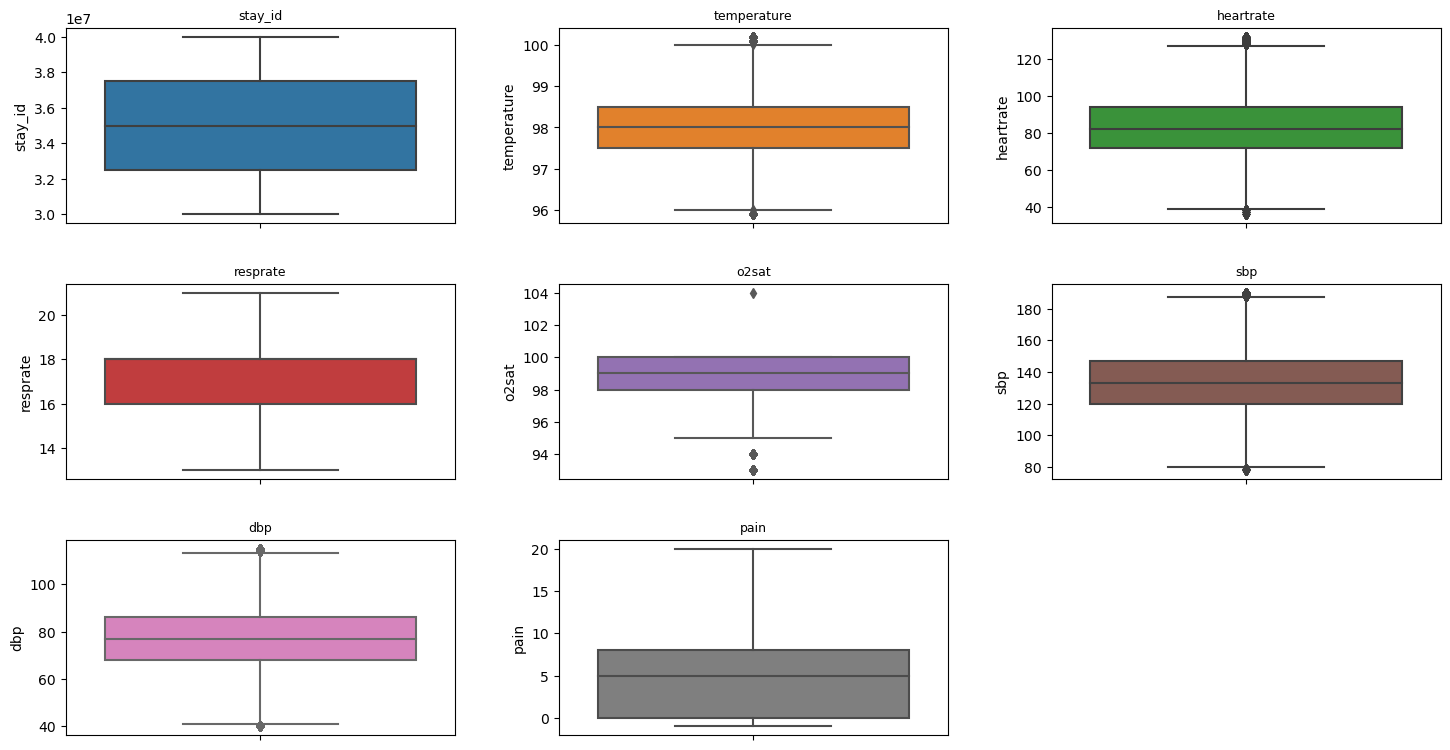

In [27]:
columnas = ['stay_id', 'temperature', 'heartrate', 'resprate',
            'o2sat', 'sbp', 'dbp','pain']

f, axes = plt.subplots(3, 3, figsize=(15, 8))
axes = axes.flatten()

def create_boxplot_styled(column, ax, color):
    sns.boxplot(y=column, data=df, ax=ax, color=color)
    ax.set_title(column, fontsize=9)
    ax.set_xlabel("")

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
          "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#aec7e8"]

for i, col in enumerate(columnas):
    create_boxplot_styled(col, axes[i], colors[i])

for i in range(len(columnas), len(axes)):
    f.delaxes(axes[i])

plt.tight_layout(pad=2.5)

plt.show()


In [28]:
# sns.pairplot(x_vars=['temperature','pain'], y_vars='acuity', height=4, aspect=1, kind='reg', data=df)
# plt.show()

#### **Correlation**

In [29]:
correlation_matrix = df.corr()

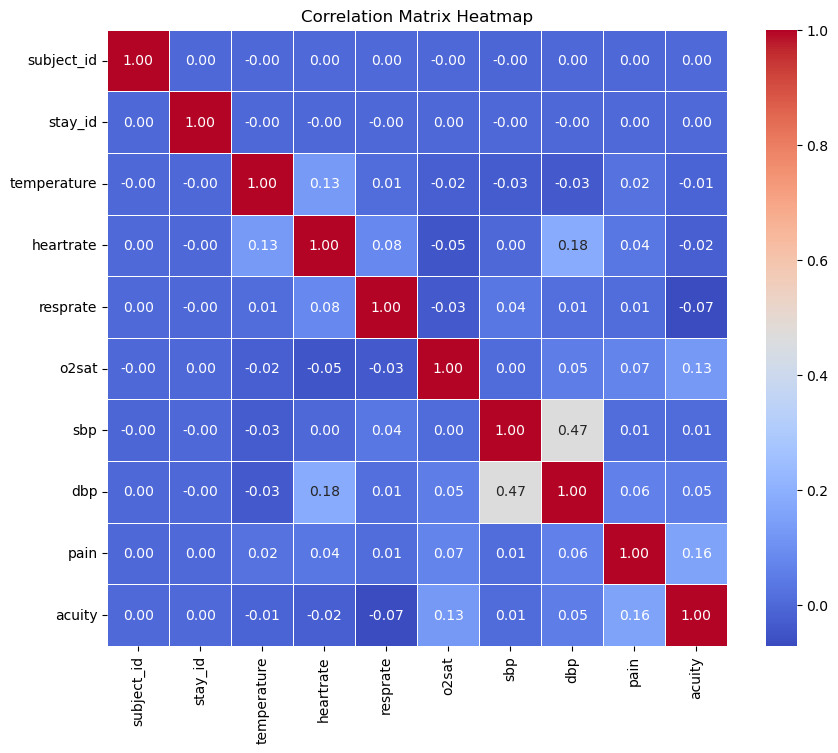

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [31]:
df.corr()['acuity']

subject_id     0.001776
stay_id        0.001188
temperature   -0.009639
heartrate     -0.021251
resprate      -0.070564
o2sat          0.129028
sbp            0.007446
dbp            0.053843
pain           0.158339
acuity         1.000000
Name: acuity, dtype: float64

## **Normalization**

In [32]:
# Columns to normalize
columns_to_scale = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp','pain']

# Extract the columns to be normalized
data_to_scale = df[columns_to_scale]

# Initialize the MinMaxScaler
scaler = StandardScaler()

# Fit and transform the data using the scaler
scaled_data = scaler.fit_transform(data_to_scale)

# Replace the original columns with the normalized ones
df[columns_to_scale] = scaled_data



In [33]:
df['acuity'] =df['acuity'].astype(int)
df

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity
0,10000032,33258284,0.500523,-0.856084,-0.823727,-0.936774,-1.408989,-1.059368,-1.131208,3
1,10000032,35968195,1.808144,1.332381,0.516529,-1.533364,-1.408989,-1.505355,1.423408,3
2,10000032,38112554,1.154334,0.269412,0.516529,-0.936774,-0.906302,0.798911,1.423408,3
3,10000032,39399961,0.892809,-0.418391,-0.823727,-0.340185,-1.911676,-2.025673,2.189793,2
4,10000084,35203156,-0.676337,-0.355864,-0.823727,0.852995,-1.006839,-0.464719,-1.131208,2
...,...,...,...,...,...,...,...,...,...,...
336296,19999784,34149746,1.023571,0.519522,0.516529,0.852995,-0.604689,-0.018732,-1.131208,3
336297,19999784,35692999,0.762047,-0.230809,0.516529,0.852995,1.355791,1.690885,-1.131208,3
336298,19999784,37972930,-0.022526,0.456995,-0.823727,0.256405,0.702298,0.947573,0.146100,2
336299,19999828,30712109,0.108236,-0.043226,0.516529,0.852995,-1.358720,-0.167394,0.912485,2


#### Mapping the Target class

In [34]:
df['acuity']=df['acuity']-1

In [35]:
df

,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity
0,10000032,33258284,0.500523,-0.856084,-0.823727,-0.936774,-1.408989,-1.059368,-1.131208,2
1,10000032,35968195,1.808144,1.332381,0.516529,-1.533364,-1.408989,-1.505355,1.423408,2
2,10000032,38112554,1.154334,0.269412,0.516529,-0.936774,-0.906302,0.798911,1.423408,2
3,10000032,39399961,0.892809,-0.418391,-0.823727,-0.340185,-1.911676,-2.025673,2.189793,1
4,10000084,35203156,-0.676337,-0.355864,-0.823727,0.852995,-1.006839,-0.464719,-1.131208,1
...,...,...,...,...,...,...,...,...,...,...
336296,19999784,34149746,1.023571,0.519522,0.516529,0.852995,-0.604689,-0.018732,-1.131208,2
336297,19999784,35692999,0.762047,-0.230809,0.516529,0.852995,1.355791,1.690885,-1.131208,2
336298,19999784,37972930,-0.022526,0.456995,-0.823727,0.256405,0.702298,0.947573,0.146100,1
336299,19999828,30712109,0.108236,-0.043226,0.516529,0.852995,-1.358720,-0.167394,0.912485,1


## **Modeling**
Creating the base model


In [36]:
# Drop 'subject_id' and 'stay_id' columns
df = df.drop(['subject_id', 'stay_id'], axis=1)

In [37]:
%%time
# Define features and target variable
features = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp','pain']
target = 'acuity'

# Split the data into features (X) and target variable (y)
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifiers = {
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(),
    'XGBoost': XGBClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
}


# Train and evaluate each classifier
for clf_name, clf in classifiers.items():
    # Fit the model to the training data
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)



    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{clf_name} Accuracy: {accuracy:.5f}')

    # Display classification report
    print(f'{clf_name} Classification Report:')
    print(classification_report(y_test, y_pred, zero_division=1))
    print('*' * 50)

RandomForest Accuracy: 0.58190
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.17      0.27      1337
           1       0.45      0.29      0.35     21109
           2       0.62      0.83      0.71     39496
           3       0.14      0.01      0.01      5319

    accuracy                           0.58     67261
   macro avg       0.46      0.32      0.34     67261
weighted avg       0.53      0.58      0.53     67261

**************************************************
LogisticRegression Accuracy: 0.59205
LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1337
           1       0.51      0.12      0.20     21109
           2       0.60      0.94      0.73     39496
           3       1.00      0.00      0.00      5319

    accuracy                           0.59     67261
   macro avg       0.78      0.27      0.2

In [46]:
xgb_clf = classifiers['XGBoost']
with open('pickel.pkl', 'wb') as file:
    pickle.dump(xgb_clf, file)

### **Hyperparameter Tunning**

 xgboost= {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

In [37]:
%%time
from sklearn.model_selection import GridSearchCV

# Define hyperparameters grid 
params = {
    'n_estimators': [ 200],
    'max_depth': [3,],
    'learning_rate': [0.1]
}

# Define classifiers with hyperparameter grids
classifiers = {
    'XGBoost': (XGBClassifier(), params),
    'GradientBoosting': (GradientBoostingClassifier(), params)
}

# Train and evaluate each classifier
for clf_name, (clf, params) in classifiers.items():
    # Perform Grid Search for hyperparameter tuning
    grid_search = GridSearchCV(clf, params, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_clf = grid_search.best_estimator_

    # Make predictions on the test data using the best model
    y_pred = best_clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{clf_name} Accuracy: {accuracy:.5f}')

    # Display classification report
    print(f'{clf_name} Classification Report:')
    print(classification_report(y_test, y_pred, zero_division=1))
    print(f'Best Parameters: {grid_search.best_params_}')
    print('*' * 50)


XGBoost Accuracy: 0.60316
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.19      0.29      1337
           1       0.52      0.21      0.30     21109
           2       0.61      0.91      0.73     39496
           3       1.00      0.00      0.00      5319

    accuracy                           0.60     67261
   macro avg       0.71      0.33      0.33     67261
weighted avg       0.62      0.60      0.53     67261

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
**************************************************
GradientBoosting Accuracy: 0.60253
GradientBoosting Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.18      0.29      1337
           1       0.52      0.21      0.30     21109
           2       0.61      0.91      0.73     39496
           3       0.00      0.00      0.00      5319

    accuracy                     

### **Oversampling Target Class**

In [38]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Class distribution before oversampling:", Counter(y_train))

Class distribution before oversampling: Counter({2: 157557, 1: 84995, 3: 21196, 0: 5292})


In [39]:
# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
print("Class distribution after oversampling:", Counter(y_train_resampled))

Class distribution after oversampling: Counter({2: 157557, 3: 157557, 1: 157557, 0: 157557})


In [40]:
for name, clf in classifiers.items():
    if name == "Gradient Boosting":
        clf.fit(X_train_resampled, y_train_resampled)
        y_pred = clf.predict(X_test)
        y_pred_original = label_encoder.inverse_transform(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.5f}')

# Display classification report
print(f'Classification Report:')
print(classification_report(y_test, y_pred, zero_division=1))
print('-' * 50)

Accuracy: 0.60253
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.18      0.29      1337
           1       0.52      0.21      0.30     21109
           2       0.61      0.91      0.73     39496
           3       0.00      0.00      0.00      5319

    accuracy                           0.60     67261
   macro avg       0.45      0.32      0.33     67261
weighted avg       0.54      0.60      0.53     67261

--------------------------------------------------


### Ensembling Logistic Regression, Xgboost, Gradient boosting

In [41]:
from sklearn.ensemble import VotingClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# Define features and target variable
features = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain']
target = 'acuity'

# Split the data into features (X) and target variable (y)
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define individual classifiers
logistic_classifier = LogisticRegression()
xgboost_classifier = XGBClassifier()
gradient_boosting_classifier = GradientBoostingClassifier()

# Create a Bagging ensemble using VotingClassifier
bagging_clf = VotingClassifier(
    estimators=[
        ('LogisticRegression', logistic_classifier),
        ('XGBoost', xgboost_classifier),
        ('GradientBoosting', gradient_boosting_classifier)
    ],
    voting='hard'  # 'hard' voting combines the predictions by majority voting
)

# Train and evaluate the BaggingClassifier
bagging_clf.fit(X_train, y_train)
y_pred_bagging = bagging_clf.predict(X_test)


# Evaluate the BaggingClassifier
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print(f'Bagging Classifier Accuracy: {accuracy_bagging:.5f}')

# Display classification report for BaggingClassifier
print('Bagging Classifier Classification Report:')
print(classification_report(y_test, y_pred_bagging, zero_division=1))



Bagging Classifier Accuracy: 0.60282
Bagging Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.19      0.29      1337
           1       0.53      0.19      0.28     21109
           2       0.61      0.92      0.73     39496
           3       1.00      0.00      0.00      5319

    accuracy                           0.60     67261
   macro avg       0.71      0.32      0.33     67261
weighted avg       0.62      0.60      0.52     67261



#### Four classifier ensemble

In [49]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
# Define features and target variable
features = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain']
target = 'acuity'

# Split the data into features (X) and target variable (y)
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Define individual classifiers
random_forest_classifier = RandomForestClassifier()
logistic_classifier = LogisticRegression()
xgboost_classifier = XGBClassifier()
gradient_boosting_classifier = GradientBoostingClassifier()

# Create different combinations of four classifiers
classifiers_combinations = [
    [('RandomForest', random_forest_classifier), ('LogisticRegression', logistic_classifier), ('XGBoost', xgboost_classifier), ('GradientBoosting', gradient_boosting_classifier)],
]

for i, combination in enumerate(classifiers_combinations):
   

    # Create a VotingClassifier with the specified combination
    voting_clf = VotingClassifier(estimators=combination, voting='hard')

    # Initialize BaggingClassifier with the VotingClassifier as the base estimator
    bagging_clf = BaggingClassifier(estimator=voting_clf, n_estimators=10, random_state=42)

    # Train and evaluate the BaggingClassifier
    bagging_clf.fit(X_train, y_train)
    y_pred_bagging = bagging_clf.predict(X_test)


    # Calculate and print the time taken
   
    print(f'Combination {i + 1} - Time taken: {elapsed_time:.2f} seconds')
    print(f'Combination {i + 1} - Bagging Classifier Accuracy: {accuracy_score(y_test, y_pred_bagging):.5f}')
    print(f'Combination {i + 1} - Bagging Classifier Classification Report:')
    print(classification_report(y_test, y_pred_bagging, zero_division=1))
    print('-' * 50)


NameError: name 'elapsed_time' is not defined